# Action Recognition @ UCF101  
---
We will be doing action recognition using Recurrent Neural Network (RNN), (Long-Short Term Memory) LSTM in particular. A dataset called UCF101, which consists of 101 different actions/classes and for each action, there will be 145 samples. We tagged each sample into either training or testing. Each sample is supposed to be a short video, but we sampled 25 frames from each videos to reduce the data amount. Consequently, a training sample is a tuple of 3D volume with one dimension encoding *temporal correlation* between frames and a label indicating what action it is.

To tackle this problem, we aim to build a neural network that can not only capture spatial information of each frame but also temporal information between frames. Fortunately, you don't have to do this on your own. RNN — a type of neural network designed to deal with time-series data — is right here for you to use. In particular, you will be using LSTM for this task.

Instead of training a end-to-end neural network from scratch whose computation is prohibitively expensive for CPUs. We divide this into two steps: feature extraction and modelling.

- **Feature extraction**. We shall use the pretrained VGG network to extract features from each frame. Specifically, we use the activations of the first fully connected layer `torchvision.models.vgg16` (4096 dim) as features of each video frame. This will result into a 4096x25 matrix for each video. 

    - We use `scipy.io.savemat()` to save feature to '.mat' file and `scipy.io.loadmat()` load feature.
    - Then norm our images using `torchvision.transforms`
    ```
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    prep = transforms.Compose([ transforms.ToTensor(), normalize ])
    prep(img)
    
    ```
    More detils of image preprocessing in PyTorch can be found at http://pytorch.org/tutorials/beginner/data_loading_tutorial.html
    
- **Modelling**. With the extracted features, we can build an LSTM network which takes a 4096x25 sample as input, and outputs the action label of that sample.
- **Evaluation**. After training the network, we can evaluate our model with the testing data by computing the prediction accuracy. Moreover, we can compare the result of our network with that of support vector machine (SVM) (stacking the 4096x25 feature matrix to a long vector and train a SVM).

Notice that the size of the raw images is 256x340, whereas VGG16 takes 224x224 images as inputs. To solve this problem, instead of resizing the images which unfavorably changes the spatial ratio, we take a better solution: Cropping five 224x224 images at the image center and four corners and compute the 4096-dim VGG16 features for each of them, and average these five 4096-dim feature to get final feature representation for the raw image.

## Dataset
Download dataset at [UCF101](http://vision.cs.stonybrook.edu/~yangwang/public/UCF101_dimitris_course.zip). 

The dataset is consist of the following two parts: video images and extracted features.

### 1. Video Images  

UCF101 dataset contains 101 actions and 13,320 videos in total.  

+ `annos/actions.txt`  
  + lists all the actions (`ApplyEyeMakeup`, .., `YoYo`)   
  
+ `annots/videos_labels_subsets.txt`  
  + lists all the videos (`v_000001`, .., `v_013320`)  
  + labels (`1`, .., `101`)  
  + subsets (`1` for train, `2` for test)  

+ `images_class1/`  
  + contains videos belonging to class 1 (`ApplyEyeMakeup`)  
  + each video folder contains 25 frames  


### 2. Video Features

+ `extract_vgg16_relu6.py`  
  + used to extract video features  
     + Given an image (size: 256x340), we get 5 crops (size: 224x224) at the image center and four corners. The `vgg16-relu6` features are extracted for all 5 crops and subsequently averaged to form a single feature vector (size: 4096).  
     + Given a video, we process its 25 images seuqentially. In the end, each video is represented as a feature sequence (size: 4096 x 25).  
  + written in PyTorch; supports both CPU and GPU.  

+ `vgg16_relu6/`  
   + contains all the video features, EXCEPT those belonging to class 1 (`ApplyEyeMakeup`)  
   + you need to run script `extract_vgg16_relu6.py` to complete the feature extracting process   


## Some Tutorials
- Good materials for understanding RNN and LSTM
    - http://blog.echen.me
    - http://karpathy.github.io/2015/05/21/rnn-effectiveness/
    - http://colah.github.io/posts/2015-08-Understanding-LSTMs/
- Implementing RNN and LSTM with PyTorch
    - [LSTM with PyTorch](http://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py)
    - [RNN with PyTorch](http://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)

In [27]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import torch.nn as nn
from torchvision import datasets, models, transforms
import torch
import scipy.io 
from time import time
import pickle
import itertools

In [8]:
annotations = open('annos/videos_labels_subsets.txt','r')
annotations_dict = {}
# print(len(annotations.readlines()))
train  = 0
test = 0
for lines in annotations.readlines():
    s = lines.split()
    if int(s[1]) < 16:
        annotations_dict[s[0]] = (s[1],s[2])    # s[0] filename s[1] class label s[2] train/test
        if int(s[2]) == 1:        # 1 is for train
            train = train + 1
        elif int(s[2]) == 2:      # 2 is for test
            test = test + 1

# print(train)
# print(test)

In [9]:
train_data = []
train_label = []
test_data = []
test_label = []

for filename in sorted(os.listdir('vgg16_relu6/')):
    if filename.split('.')[0] in annotations_dict.keys():
        class_number, label = annotations_dict[filename.split('.')[0]]
        temp_data = scipy.io.loadmat('vgg16_relu6/' + filename)
        data = temp_data['Feature']
        if label == '1':
            train_data.append(data)
            train_label.append(int(class_number)-1)
        elif label == '2':
            test_data.append(data)
            test_label.append(int(class_number)-1)
        
print(type(test_data[0]))


"""
convert to tensor and use DataLoader for shuffling and batching
"""
tensor_train = TensorDataset(torch.FloatTensor(train_data), torch.LongTensor(train_label))

train_load = DataLoader(dataset = tensor_train,shuffle = True,batch_size = 5)


"""
convert to tensor and use DataLoader for shuffling and batching
"""
tensor_test = TensorDataset(torch.FloatTensor(test_data), torch.LongTensor(test_label))

test_load = DataLoader(dataset = tensor_test,shuffle = True,batch_size = 5)

print(len(train_data))

print(len(test_data))

print(len(train_load))

<class 'numpy.ndarray'>
1442
568
289


In [37]:
"""
At this stage I have the train/test data split up along with their repective labels stored in lists
Each video is stored as 25*4096 feature matrix.
"""

"""
Device check
"""
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# print(device)

# This remains constant
num_classes = 15  
batch_size = 5
sequence_length = 4096
input_size = 25
"""
Hyper parameters for tuning:-
"""
hidden_size = 128
num_layers = 2
num_epochs = 20
learning_rate = 0.001


# Recurrent neural network (many-to-one)
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)   

In [38]:
"""
Training the LSTM for first 15 classes as mentioned
"""

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model

t0 = time()

total_step = len(train_load)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_load):
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
print('Training complete in {:.0f}m {:.0f}s'.format((time()-t0) // 60, (time()-t0) % 60))

Epoch [1/20], Step [1/289], Loss: 2.6829
Epoch [1/20], Step [2/289], Loss: 2.7382
Epoch [1/20], Step [3/289], Loss: 2.6829
Epoch [1/20], Step [4/289], Loss: 2.6993
Epoch [1/20], Step [5/289], Loss: 2.7469
Epoch [1/20], Step [6/289], Loss: 2.7473
Epoch [1/20], Step [7/289], Loss: 2.7098
Epoch [1/20], Step [8/289], Loss: 2.7505
Epoch [1/20], Step [9/289], Loss: 2.6844
Epoch [1/20], Step [10/289], Loss: 2.6678
Epoch [1/20], Step [11/289], Loss: 2.7168
Epoch [1/20], Step [12/289], Loss: 2.6575
Epoch [1/20], Step [13/289], Loss: 2.6372
Epoch [1/20], Step [14/289], Loss: 2.7041
Epoch [1/20], Step [15/289], Loss: 2.6968
Epoch [1/20], Step [16/289], Loss: 2.4306
Epoch [1/20], Step [17/289], Loss: 2.5330
Epoch [1/20], Step [18/289], Loss: 2.6702
Epoch [1/20], Step [19/289], Loss: 2.3903
Epoch [1/20], Step [20/289], Loss: 2.3891
Epoch [1/20], Step [21/289], Loss: 2.3295
Epoch [1/20], Step [22/289], Loss: 2.6591
Epoch [1/20], Step [23/289], Loss: 2.2348
Epoch [1/20], Step [24/289], Loss: 2.6434
E

Epoch [1/20], Step [195/289], Loss: 1.4137
Epoch [1/20], Step [196/289], Loss: 2.5342
Epoch [1/20], Step [197/289], Loss: 2.0155
Epoch [1/20], Step [198/289], Loss: 1.1526
Epoch [1/20], Step [199/289], Loss: 2.4490
Epoch [1/20], Step [200/289], Loss: 1.4358
Epoch [1/20], Step [201/289], Loss: 2.0889
Epoch [1/20], Step [202/289], Loss: 2.0595
Epoch [1/20], Step [203/289], Loss: 1.7559
Epoch [1/20], Step [204/289], Loss: 1.9462
Epoch [1/20], Step [205/289], Loss: 1.9386
Epoch [1/20], Step [206/289], Loss: 0.7809
Epoch [1/20], Step [207/289], Loss: 1.6995
Epoch [1/20], Step [208/289], Loss: 1.5143
Epoch [1/20], Step [209/289], Loss: 1.3225
Epoch [1/20], Step [210/289], Loss: 1.7220
Epoch [1/20], Step [211/289], Loss: 1.1181
Epoch [1/20], Step [212/289], Loss: 1.6402
Epoch [1/20], Step [213/289], Loss: 1.8130
Epoch [1/20], Step [214/289], Loss: 1.1020
Epoch [1/20], Step [215/289], Loss: 1.2085
Epoch [1/20], Step [216/289], Loss: 1.4576
Epoch [1/20], Step [217/289], Loss: 1.8693
Epoch [1/20

Epoch [2/20], Step [100/289], Loss: 0.4724
Epoch [2/20], Step [101/289], Loss: 0.7115
Epoch [2/20], Step [102/289], Loss: 0.9730
Epoch [2/20], Step [103/289], Loss: 1.8926
Epoch [2/20], Step [104/289], Loss: 0.4422
Epoch [2/20], Step [105/289], Loss: 1.0885
Epoch [2/20], Step [106/289], Loss: 1.8596
Epoch [2/20], Step [107/289], Loss: 0.8956
Epoch [2/20], Step [108/289], Loss: 0.9661
Epoch [2/20], Step [109/289], Loss: 2.6901
Epoch [2/20], Step [110/289], Loss: 1.1983
Epoch [2/20], Step [111/289], Loss: 1.1641
Epoch [2/20], Step [112/289], Loss: 1.1803
Epoch [2/20], Step [113/289], Loss: 1.4560
Epoch [2/20], Step [114/289], Loss: 1.0405
Epoch [2/20], Step [115/289], Loss: 1.8505
Epoch [2/20], Step [116/289], Loss: 1.1511
Epoch [2/20], Step [117/289], Loss: 1.6761
Epoch [2/20], Step [118/289], Loss: 1.3429
Epoch [2/20], Step [119/289], Loss: 1.5914
Epoch [2/20], Step [120/289], Loss: 0.8604
Epoch [2/20], Step [121/289], Loss: 0.5776
Epoch [2/20], Step [122/289], Loss: 0.2788
Epoch [2/20

Epoch [3/20], Step [2/289], Loss: 0.6321
Epoch [3/20], Step [3/289], Loss: 0.8723
Epoch [3/20], Step [4/289], Loss: 1.2907
Epoch [3/20], Step [5/289], Loss: 0.4229
Epoch [3/20], Step [6/289], Loss: 0.9334
Epoch [3/20], Step [7/289], Loss: 0.5835
Epoch [3/20], Step [8/289], Loss: 0.4651
Epoch [3/20], Step [9/289], Loss: 0.7638
Epoch [3/20], Step [10/289], Loss: 0.7031
Epoch [3/20], Step [11/289], Loss: 0.2784
Epoch [3/20], Step [12/289], Loss: 0.5071
Epoch [3/20], Step [13/289], Loss: 0.3910
Epoch [3/20], Step [14/289], Loss: 1.1255
Epoch [3/20], Step [15/289], Loss: 0.3119
Epoch [3/20], Step [16/289], Loss: 0.8894
Epoch [3/20], Step [17/289], Loss: 0.2060
Epoch [3/20], Step [18/289], Loss: 1.0705
Epoch [3/20], Step [19/289], Loss: 1.1782
Epoch [3/20], Step [20/289], Loss: 0.5540
Epoch [3/20], Step [21/289], Loss: 0.4046
Epoch [3/20], Step [22/289], Loss: 0.5944
Epoch [3/20], Step [23/289], Loss: 0.5977
Epoch [3/20], Step [24/289], Loss: 0.4208
Epoch [3/20], Step [25/289], Loss: 0.3305


Epoch [3/20], Step [195/289], Loss: 0.7311
Epoch [3/20], Step [196/289], Loss: 1.0400
Epoch [3/20], Step [197/289], Loss: 0.6873
Epoch [3/20], Step [198/289], Loss: 0.3150
Epoch [3/20], Step [199/289], Loss: 0.9898
Epoch [3/20], Step [200/289], Loss: 0.4942
Epoch [3/20], Step [201/289], Loss: 0.3136
Epoch [3/20], Step [202/289], Loss: 0.8338
Epoch [3/20], Step [203/289], Loss: 0.5758
Epoch [3/20], Step [204/289], Loss: 0.4913
Epoch [3/20], Step [205/289], Loss: 0.4175
Epoch [3/20], Step [206/289], Loss: 0.2293
Epoch [3/20], Step [207/289], Loss: 0.2331
Epoch [3/20], Step [208/289], Loss: 0.7945
Epoch [3/20], Step [209/289], Loss: 1.6191
Epoch [3/20], Step [210/289], Loss: 0.3629
Epoch [3/20], Step [211/289], Loss: 0.7201
Epoch [3/20], Step [212/289], Loss: 0.4866
Epoch [3/20], Step [213/289], Loss: 1.4229
Epoch [3/20], Step [214/289], Loss: 0.5548
Epoch [3/20], Step [215/289], Loss: 0.2215
Epoch [3/20], Step [216/289], Loss: 0.7074
Epoch [3/20], Step [217/289], Loss: 0.1397
Epoch [3/20

Epoch [4/20], Step [100/289], Loss: 0.4486
Epoch [4/20], Step [101/289], Loss: 0.7267
Epoch [4/20], Step [102/289], Loss: 0.0457
Epoch [4/20], Step [103/289], Loss: 0.1716
Epoch [4/20], Step [104/289], Loss: 0.2367
Epoch [4/20], Step [105/289], Loss: 0.7829
Epoch [4/20], Step [106/289], Loss: 0.0976
Epoch [4/20], Step [107/289], Loss: 0.2577
Epoch [4/20], Step [108/289], Loss: 0.0219
Epoch [4/20], Step [109/289], Loss: 0.6228
Epoch [4/20], Step [110/289], Loss: 0.4082
Epoch [4/20], Step [111/289], Loss: 0.6696
Epoch [4/20], Step [112/289], Loss: 0.5880
Epoch [4/20], Step [113/289], Loss: 0.7315
Epoch [4/20], Step [114/289], Loss: 0.1610
Epoch [4/20], Step [115/289], Loss: 0.4749
Epoch [4/20], Step [116/289], Loss: 0.4933
Epoch [4/20], Step [117/289], Loss: 0.9393
Epoch [4/20], Step [118/289], Loss: 0.0928
Epoch [4/20], Step [119/289], Loss: 0.0919
Epoch [4/20], Step [120/289], Loss: 0.1302
Epoch [4/20], Step [121/289], Loss: 0.3235
Epoch [4/20], Step [122/289], Loss: 0.3274
Epoch [4/20

Epoch [5/20], Step [2/289], Loss: 0.2346
Epoch [5/20], Step [3/289], Loss: 0.5270
Epoch [5/20], Step [4/289], Loss: 0.1778
Epoch [5/20], Step [5/289], Loss: 0.6211
Epoch [5/20], Step [6/289], Loss: 0.0531
Epoch [5/20], Step [7/289], Loss: 0.6446
Epoch [5/20], Step [8/289], Loss: 0.5502
Epoch [5/20], Step [9/289], Loss: 0.2127
Epoch [5/20], Step [10/289], Loss: 0.1643
Epoch [5/20], Step [11/289], Loss: 0.9546
Epoch [5/20], Step [12/289], Loss: 0.2384
Epoch [5/20], Step [13/289], Loss: 1.0916
Epoch [5/20], Step [14/289], Loss: 0.0657
Epoch [5/20], Step [15/289], Loss: 0.2029
Epoch [5/20], Step [16/289], Loss: 0.6919
Epoch [5/20], Step [17/289], Loss: 1.0490
Epoch [5/20], Step [18/289], Loss: 0.6391
Epoch [5/20], Step [19/289], Loss: 0.5902
Epoch [5/20], Step [20/289], Loss: 0.0880
Epoch [5/20], Step [21/289], Loss: 0.6919
Epoch [5/20], Step [22/289], Loss: 0.4399
Epoch [5/20], Step [23/289], Loss: 0.6768
Epoch [5/20], Step [24/289], Loss: 0.4991
Epoch [5/20], Step [25/289], Loss: 0.5610


Epoch [5/20], Step [195/289], Loss: 0.0720
Epoch [5/20], Step [196/289], Loss: 0.1657
Epoch [5/20], Step [197/289], Loss: 0.2082
Epoch [5/20], Step [198/289], Loss: 0.2816
Epoch [5/20], Step [199/289], Loss: 0.1600
Epoch [5/20], Step [200/289], Loss: 0.1011
Epoch [5/20], Step [201/289], Loss: 0.0303
Epoch [5/20], Step [202/289], Loss: 0.0461
Epoch [5/20], Step [203/289], Loss: 0.0911
Epoch [5/20], Step [204/289], Loss: 0.1126
Epoch [5/20], Step [205/289], Loss: 0.3529
Epoch [5/20], Step [206/289], Loss: 0.1363
Epoch [5/20], Step [207/289], Loss: 0.4117
Epoch [5/20], Step [208/289], Loss: 0.2023
Epoch [5/20], Step [209/289], Loss: 0.4890
Epoch [5/20], Step [210/289], Loss: 0.1811
Epoch [5/20], Step [211/289], Loss: 0.3132
Epoch [5/20], Step [212/289], Loss: 0.3380
Epoch [5/20], Step [213/289], Loss: 0.6034
Epoch [5/20], Step [214/289], Loss: 0.0303
Epoch [5/20], Step [215/289], Loss: 0.2179
Epoch [5/20], Step [216/289], Loss: 0.2758
Epoch [5/20], Step [217/289], Loss: 0.8614
Epoch [5/20

Epoch [6/20], Step [100/289], Loss: 0.4279
Epoch [6/20], Step [101/289], Loss: 0.0231
Epoch [6/20], Step [102/289], Loss: 0.0913
Epoch [6/20], Step [103/289], Loss: 0.3889
Epoch [6/20], Step [104/289], Loss: 0.0123
Epoch [6/20], Step [105/289], Loss: 0.0766
Epoch [6/20], Step [106/289], Loss: 0.1225
Epoch [6/20], Step [107/289], Loss: 0.2593
Epoch [6/20], Step [108/289], Loss: 0.8478
Epoch [6/20], Step [109/289], Loss: 0.1070
Epoch [6/20], Step [110/289], Loss: 0.4873
Epoch [6/20], Step [111/289], Loss: 0.0463
Epoch [6/20], Step [112/289], Loss: 0.0706
Epoch [6/20], Step [113/289], Loss: 0.1319
Epoch [6/20], Step [114/289], Loss: 0.1464
Epoch [6/20], Step [115/289], Loss: 0.0946
Epoch [6/20], Step [116/289], Loss: 0.0411
Epoch [6/20], Step [117/289], Loss: 0.0925
Epoch [6/20], Step [118/289], Loss: 0.0645
Epoch [6/20], Step [119/289], Loss: 0.1911
Epoch [6/20], Step [120/289], Loss: 0.0563
Epoch [6/20], Step [121/289], Loss: 0.0486
Epoch [6/20], Step [122/289], Loss: 0.0827
Epoch [6/20

Epoch [7/20], Step [2/289], Loss: 0.2308
Epoch [7/20], Step [3/289], Loss: 0.3997
Epoch [7/20], Step [4/289], Loss: 0.1682
Epoch [7/20], Step [5/289], Loss: 0.0285
Epoch [7/20], Step [6/289], Loss: 0.0361
Epoch [7/20], Step [7/289], Loss: 0.2928
Epoch [7/20], Step [8/289], Loss: 0.2562
Epoch [7/20], Step [9/289], Loss: 0.0229
Epoch [7/20], Step [10/289], Loss: 0.0582
Epoch [7/20], Step [11/289], Loss: 0.1552
Epoch [7/20], Step [12/289], Loss: 0.1280
Epoch [7/20], Step [13/289], Loss: 0.0034
Epoch [7/20], Step [14/289], Loss: 0.2305
Epoch [7/20], Step [15/289], Loss: 0.1151
Epoch [7/20], Step [16/289], Loss: 0.1293
Epoch [7/20], Step [17/289], Loss: 0.0963
Epoch [7/20], Step [18/289], Loss: 0.1527
Epoch [7/20], Step [19/289], Loss: 0.0201
Epoch [7/20], Step [20/289], Loss: 0.0870
Epoch [7/20], Step [21/289], Loss: 0.0177
Epoch [7/20], Step [22/289], Loss: 0.2189
Epoch [7/20], Step [23/289], Loss: 0.0276
Epoch [7/20], Step [24/289], Loss: 0.1569
Epoch [7/20], Step [25/289], Loss: 0.0312


Epoch [7/20], Step [195/289], Loss: 0.0205
Epoch [7/20], Step [196/289], Loss: 0.0658
Epoch [7/20], Step [197/289], Loss: 0.0526
Epoch [7/20], Step [198/289], Loss: 0.0153
Epoch [7/20], Step [199/289], Loss: 0.0114
Epoch [7/20], Step [200/289], Loss: 0.0781
Epoch [7/20], Step [201/289], Loss: 0.2023
Epoch [7/20], Step [202/289], Loss: 0.0423
Epoch [7/20], Step [203/289], Loss: 0.0741
Epoch [7/20], Step [204/289], Loss: 0.0155
Epoch [7/20], Step [205/289], Loss: 0.0645
Epoch [7/20], Step [206/289], Loss: 0.3731
Epoch [7/20], Step [207/289], Loss: 0.0113
Epoch [7/20], Step [208/289], Loss: 0.2205
Epoch [7/20], Step [209/289], Loss: 0.6109
Epoch [7/20], Step [210/289], Loss: 0.0085
Epoch [7/20], Step [211/289], Loss: 0.0209
Epoch [7/20], Step [212/289], Loss: 0.0122
Epoch [7/20], Step [213/289], Loss: 0.0628
Epoch [7/20], Step [214/289], Loss: 0.0089
Epoch [7/20], Step [215/289], Loss: 0.0213
Epoch [7/20], Step [216/289], Loss: 0.1220
Epoch [7/20], Step [217/289], Loss: 0.0257
Epoch [7/20

Epoch [8/20], Step [100/289], Loss: 0.0124
Epoch [8/20], Step [101/289], Loss: 0.0734
Epoch [8/20], Step [102/289], Loss: 0.0894
Epoch [8/20], Step [103/289], Loss: 0.0745
Epoch [8/20], Step [104/289], Loss: 0.0361
Epoch [8/20], Step [105/289], Loss: 0.0569
Epoch [8/20], Step [106/289], Loss: 0.6951
Epoch [8/20], Step [107/289], Loss: 0.0366
Epoch [8/20], Step [108/289], Loss: 0.0045
Epoch [8/20], Step [109/289], Loss: 0.0147
Epoch [8/20], Step [110/289], Loss: 0.0156
Epoch [8/20], Step [111/289], Loss: 0.0360
Epoch [8/20], Step [112/289], Loss: 0.4125
Epoch [8/20], Step [113/289], Loss: 0.0557
Epoch [8/20], Step [114/289], Loss: 0.0077
Epoch [8/20], Step [115/289], Loss: 0.0058
Epoch [8/20], Step [116/289], Loss: 0.2485
Epoch [8/20], Step [117/289], Loss: 0.0032
Epoch [8/20], Step [118/289], Loss: 0.0071
Epoch [8/20], Step [119/289], Loss: 0.0296
Epoch [8/20], Step [120/289], Loss: 0.0383
Epoch [8/20], Step [121/289], Loss: 0.0137
Epoch [8/20], Step [122/289], Loss: 0.0940
Epoch [8/20

Epoch [9/20], Step [2/289], Loss: 0.1563
Epoch [9/20], Step [3/289], Loss: 0.0505
Epoch [9/20], Step [4/289], Loss: 0.0288
Epoch [9/20], Step [5/289], Loss: 0.0423
Epoch [9/20], Step [6/289], Loss: 0.3834
Epoch [9/20], Step [7/289], Loss: 0.0145
Epoch [9/20], Step [8/289], Loss: 0.0184
Epoch [9/20], Step [9/289], Loss: 0.0450
Epoch [9/20], Step [10/289], Loss: 0.0367
Epoch [9/20], Step [11/289], Loss: 0.0747
Epoch [9/20], Step [12/289], Loss: 0.0803
Epoch [9/20], Step [13/289], Loss: 0.0122
Epoch [9/20], Step [14/289], Loss: 0.0650
Epoch [9/20], Step [15/289], Loss: 0.1280
Epoch [9/20], Step [16/289], Loss: 0.0209
Epoch [9/20], Step [17/289], Loss: 0.0610
Epoch [9/20], Step [18/289], Loss: 0.0343
Epoch [9/20], Step [19/289], Loss: 0.2036
Epoch [9/20], Step [20/289], Loss: 0.1080
Epoch [9/20], Step [21/289], Loss: 0.0103
Epoch [9/20], Step [22/289], Loss: 0.1071
Epoch [9/20], Step [23/289], Loss: 0.0093
Epoch [9/20], Step [24/289], Loss: 0.0338
Epoch [9/20], Step [25/289], Loss: 0.2295


Epoch [9/20], Step [195/289], Loss: 0.2381
Epoch [9/20], Step [196/289], Loss: 0.0189
Epoch [9/20], Step [197/289], Loss: 0.0438
Epoch [9/20], Step [198/289], Loss: 0.0052
Epoch [9/20], Step [199/289], Loss: 0.0071
Epoch [9/20], Step [200/289], Loss: 0.0095
Epoch [9/20], Step [201/289], Loss: 0.0090
Epoch [9/20], Step [202/289], Loss: 0.0132
Epoch [9/20], Step [203/289], Loss: 0.0459
Epoch [9/20], Step [204/289], Loss: 0.0151
Epoch [9/20], Step [205/289], Loss: 0.0041
Epoch [9/20], Step [206/289], Loss: 0.0326
Epoch [9/20], Step [207/289], Loss: 0.0112
Epoch [9/20], Step [208/289], Loss: 0.0111
Epoch [9/20], Step [209/289], Loss: 0.1222
Epoch [9/20], Step [210/289], Loss: 0.0275
Epoch [9/20], Step [211/289], Loss: 0.0189
Epoch [9/20], Step [212/289], Loss: 0.0033
Epoch [9/20], Step [213/289], Loss: 0.0488
Epoch [9/20], Step [214/289], Loss: 0.0121
Epoch [9/20], Step [215/289], Loss: 0.0600
Epoch [9/20], Step [216/289], Loss: 0.0250
Epoch [9/20], Step [217/289], Loss: 0.0075
Epoch [9/20

Epoch [10/20], Step [97/289], Loss: 0.1894
Epoch [10/20], Step [98/289], Loss: 0.0048
Epoch [10/20], Step [99/289], Loss: 0.0223
Epoch [10/20], Step [100/289], Loss: 0.0427
Epoch [10/20], Step [101/289], Loss: 0.0249
Epoch [10/20], Step [102/289], Loss: 0.0152
Epoch [10/20], Step [103/289], Loss: 0.0107
Epoch [10/20], Step [104/289], Loss: 0.0078
Epoch [10/20], Step [105/289], Loss: 0.0014
Epoch [10/20], Step [106/289], Loss: 0.0474
Epoch [10/20], Step [107/289], Loss: 0.0125
Epoch [10/20], Step [108/289], Loss: 0.0254
Epoch [10/20], Step [109/289], Loss: 0.0205
Epoch [10/20], Step [110/289], Loss: 0.0271
Epoch [10/20], Step [111/289], Loss: 0.2583
Epoch [10/20], Step [112/289], Loss: 0.0065
Epoch [10/20], Step [113/289], Loss: 0.0052
Epoch [10/20], Step [114/289], Loss: 0.0515
Epoch [10/20], Step [115/289], Loss: 0.0142
Epoch [10/20], Step [116/289], Loss: 0.0117
Epoch [10/20], Step [117/289], Loss: 0.0145
Epoch [10/20], Step [118/289], Loss: 0.0092
Epoch [10/20], Step [119/289], Loss

Epoch [10/20], Step [284/289], Loss: 0.1204
Epoch [10/20], Step [285/289], Loss: 0.1436
Epoch [10/20], Step [286/289], Loss: 0.0163
Epoch [10/20], Step [287/289], Loss: 0.0097
Epoch [10/20], Step [288/289], Loss: 0.0502
Epoch [10/20], Step [289/289], Loss: 0.0327
Epoch [11/20], Step [1/289], Loss: 0.0422
Epoch [11/20], Step [2/289], Loss: 0.0144
Epoch [11/20], Step [3/289], Loss: 0.0214
Epoch [11/20], Step [4/289], Loss: 0.0731
Epoch [11/20], Step [5/289], Loss: 0.0120
Epoch [11/20], Step [6/289], Loss: 0.0063
Epoch [11/20], Step [7/289], Loss: 0.0029
Epoch [11/20], Step [8/289], Loss: 0.0911
Epoch [11/20], Step [9/289], Loss: 0.0230
Epoch [11/20], Step [10/289], Loss: 0.0313
Epoch [11/20], Step [11/289], Loss: 0.0125
Epoch [11/20], Step [12/289], Loss: 0.0165
Epoch [11/20], Step [13/289], Loss: 0.0226
Epoch [11/20], Step [14/289], Loss: 0.0210
Epoch [11/20], Step [15/289], Loss: 0.0080
Epoch [11/20], Step [16/289], Loss: 0.0183
Epoch [11/20], Step [17/289], Loss: 0.1494
Epoch [11/20],

Epoch [11/20], Step [184/289], Loss: 0.0080
Epoch [11/20], Step [185/289], Loss: 0.0035
Epoch [11/20], Step [186/289], Loss: 0.0018
Epoch [11/20], Step [187/289], Loss: 0.0018
Epoch [11/20], Step [188/289], Loss: 0.1115
Epoch [11/20], Step [189/289], Loss: 0.0047
Epoch [11/20], Step [190/289], Loss: 0.0027
Epoch [11/20], Step [191/289], Loss: 0.0024
Epoch [11/20], Step [192/289], Loss: 0.0016
Epoch [11/20], Step [193/289], Loss: 0.0026
Epoch [11/20], Step [194/289], Loss: 0.0081
Epoch [11/20], Step [195/289], Loss: 0.0097
Epoch [11/20], Step [196/289], Loss: 0.0170
Epoch [11/20], Step [197/289], Loss: 0.0080
Epoch [11/20], Step [198/289], Loss: 0.0014
Epoch [11/20], Step [199/289], Loss: 0.0142
Epoch [11/20], Step [200/289], Loss: 0.4252
Epoch [11/20], Step [201/289], Loss: 0.0016
Epoch [11/20], Step [202/289], Loss: 0.0025
Epoch [11/20], Step [203/289], Loss: 0.0048
Epoch [11/20], Step [204/289], Loss: 0.0895
Epoch [11/20], Step [205/289], Loss: 0.0197
Epoch [11/20], Step [206/289], L

Epoch [12/20], Step [84/289], Loss: 0.0048
Epoch [12/20], Step [85/289], Loss: 0.1433
Epoch [12/20], Step [86/289], Loss: 0.0424
Epoch [12/20], Step [87/289], Loss: 0.2367
Epoch [12/20], Step [88/289], Loss: 0.0022
Epoch [12/20], Step [89/289], Loss: 0.0060
Epoch [12/20], Step [90/289], Loss: 0.0112
Epoch [12/20], Step [91/289], Loss: 0.0555
Epoch [12/20], Step [92/289], Loss: 0.0137
Epoch [12/20], Step [93/289], Loss: 0.0108
Epoch [12/20], Step [94/289], Loss: 0.0039
Epoch [12/20], Step [95/289], Loss: 0.0017
Epoch [12/20], Step [96/289], Loss: 0.0066
Epoch [12/20], Step [97/289], Loss: 0.0110
Epoch [12/20], Step [98/289], Loss: 0.0538
Epoch [12/20], Step [99/289], Loss: 0.0151
Epoch [12/20], Step [100/289], Loss: 0.0079
Epoch [12/20], Step [101/289], Loss: 0.0030
Epoch [12/20], Step [102/289], Loss: 0.0077
Epoch [12/20], Step [103/289], Loss: 0.0129
Epoch [12/20], Step [104/289], Loss: 0.0208
Epoch [12/20], Step [105/289], Loss: 0.0042
Epoch [12/20], Step [106/289], Loss: 0.0216
Epoc

Epoch [12/20], Step [271/289], Loss: 0.0119
Epoch [12/20], Step [272/289], Loss: 0.0406
Epoch [12/20], Step [273/289], Loss: 0.0905
Epoch [12/20], Step [274/289], Loss: 0.0168
Epoch [12/20], Step [275/289], Loss: 0.2546
Epoch [12/20], Step [276/289], Loss: 0.0010
Epoch [12/20], Step [277/289], Loss: 0.0212
Epoch [12/20], Step [278/289], Loss: 0.0465
Epoch [12/20], Step [279/289], Loss: 0.0087
Epoch [12/20], Step [280/289], Loss: 0.1055
Epoch [12/20], Step [281/289], Loss: 0.3658
Epoch [12/20], Step [282/289], Loss: 0.1602
Epoch [12/20], Step [283/289], Loss: 0.0139
Epoch [12/20], Step [284/289], Loss: 0.0040
Epoch [12/20], Step [285/289], Loss: 0.0442
Epoch [12/20], Step [286/289], Loss: 0.0032
Epoch [12/20], Step [287/289], Loss: 0.1741
Epoch [12/20], Step [288/289], Loss: 0.1294
Epoch [12/20], Step [289/289], Loss: 0.0090
Epoch [13/20], Step [1/289], Loss: 0.0117
Epoch [13/20], Step [2/289], Loss: 0.0775
Epoch [13/20], Step [3/289], Loss: 0.0343
Epoch [13/20], Step [4/289], Loss: 0.0

Epoch [13/20], Step [171/289], Loss: 0.0032
Epoch [13/20], Step [172/289], Loss: 0.0282
Epoch [13/20], Step [173/289], Loss: 0.0020
Epoch [13/20], Step [174/289], Loss: 0.0009
Epoch [13/20], Step [175/289], Loss: 0.0152
Epoch [13/20], Step [176/289], Loss: 0.0079
Epoch [13/20], Step [177/289], Loss: 0.0139
Epoch [13/20], Step [178/289], Loss: 0.0307
Epoch [13/20], Step [179/289], Loss: 0.0027
Epoch [13/20], Step [180/289], Loss: 0.0033
Epoch [13/20], Step [181/289], Loss: 0.0033
Epoch [13/20], Step [182/289], Loss: 0.0043
Epoch [13/20], Step [183/289], Loss: 0.0109
Epoch [13/20], Step [184/289], Loss: 0.0666
Epoch [13/20], Step [185/289], Loss: 0.0040
Epoch [13/20], Step [186/289], Loss: 0.0014
Epoch [13/20], Step [187/289], Loss: 0.0128
Epoch [13/20], Step [188/289], Loss: 0.0056
Epoch [13/20], Step [189/289], Loss: 0.0066
Epoch [13/20], Step [190/289], Loss: 0.0955
Epoch [13/20], Step [191/289], Loss: 0.0072
Epoch [13/20], Step [192/289], Loss: 0.0171
Epoch [13/20], Step [193/289], L

Epoch [14/20], Step [70/289], Loss: 0.0034
Epoch [14/20], Step [71/289], Loss: 0.0096
Epoch [14/20], Step [72/289], Loss: 0.0083
Epoch [14/20], Step [73/289], Loss: 0.0024
Epoch [14/20], Step [74/289], Loss: 0.0053
Epoch [14/20], Step [75/289], Loss: 0.0071
Epoch [14/20], Step [76/289], Loss: 0.0074
Epoch [14/20], Step [77/289], Loss: 0.0120
Epoch [14/20], Step [78/289], Loss: 0.0038
Epoch [14/20], Step [79/289], Loss: 0.0159
Epoch [14/20], Step [80/289], Loss: 0.0108
Epoch [14/20], Step [81/289], Loss: 0.0323
Epoch [14/20], Step [82/289], Loss: 0.0608
Epoch [14/20], Step [83/289], Loss: 0.0088
Epoch [14/20], Step [84/289], Loss: 0.0257
Epoch [14/20], Step [85/289], Loss: 0.0099
Epoch [14/20], Step [86/289], Loss: 0.0133
Epoch [14/20], Step [87/289], Loss: 0.0061
Epoch [14/20], Step [88/289], Loss: 0.0244
Epoch [14/20], Step [89/289], Loss: 0.0213
Epoch [14/20], Step [90/289], Loss: 0.0244
Epoch [14/20], Step [91/289], Loss: 0.0035
Epoch [14/20], Step [92/289], Loss: 0.0015
Epoch [14/2

Epoch [14/20], Step [257/289], Loss: 0.0045
Epoch [14/20], Step [258/289], Loss: 0.0105
Epoch [14/20], Step [259/289], Loss: 0.0270
Epoch [14/20], Step [260/289], Loss: 0.0006
Epoch [14/20], Step [261/289], Loss: 0.0071
Epoch [14/20], Step [262/289], Loss: 0.0029
Epoch [14/20], Step [263/289], Loss: 0.0022
Epoch [14/20], Step [264/289], Loss: 0.0042
Epoch [14/20], Step [265/289], Loss: 0.0065
Epoch [14/20], Step [266/289], Loss: 0.0029
Epoch [14/20], Step [267/289], Loss: 0.0015
Epoch [14/20], Step [268/289], Loss: 0.0258
Epoch [14/20], Step [269/289], Loss: 0.1027
Epoch [14/20], Step [270/289], Loss: 0.0546
Epoch [14/20], Step [271/289], Loss: 0.0020
Epoch [14/20], Step [272/289], Loss: 0.0181
Epoch [14/20], Step [273/289], Loss: 0.0061
Epoch [14/20], Step [274/289], Loss: 0.0065
Epoch [14/20], Step [275/289], Loss: 0.0110
Epoch [14/20], Step [276/289], Loss: 0.0061
Epoch [14/20], Step [277/289], Loss: 0.0013
Epoch [14/20], Step [278/289], Loss: 0.0013
Epoch [14/20], Step [279/289], L

Epoch [15/20], Step [157/289], Loss: 0.1189
Epoch [15/20], Step [158/289], Loss: 0.0020
Epoch [15/20], Step [159/289], Loss: 0.0088
Epoch [15/20], Step [160/289], Loss: 0.0022
Epoch [15/20], Step [161/289], Loss: 0.0017
Epoch [15/20], Step [162/289], Loss: 0.0012
Epoch [15/20], Step [163/289], Loss: 0.0015
Epoch [15/20], Step [164/289], Loss: 0.0026
Epoch [15/20], Step [165/289], Loss: 0.0014
Epoch [15/20], Step [166/289], Loss: 0.0072
Epoch [15/20], Step [167/289], Loss: 0.0103
Epoch [15/20], Step [168/289], Loss: 0.0070
Epoch [15/20], Step [169/289], Loss: 0.0028
Epoch [15/20], Step [170/289], Loss: 0.0015
Epoch [15/20], Step [171/289], Loss: 0.0003
Epoch [15/20], Step [172/289], Loss: 0.0021
Epoch [15/20], Step [173/289], Loss: 0.0010
Epoch [15/20], Step [174/289], Loss: 0.0089
Epoch [15/20], Step [175/289], Loss: 0.0022
Epoch [15/20], Step [176/289], Loss: 0.1027
Epoch [15/20], Step [177/289], Loss: 0.0039
Epoch [15/20], Step [178/289], Loss: 0.0014
Epoch [15/20], Step [179/289], L

Epoch [16/20], Step [56/289], Loss: 0.0005
Epoch [16/20], Step [57/289], Loss: 0.0011
Epoch [16/20], Step [58/289], Loss: 0.0008
Epoch [16/20], Step [59/289], Loss: 0.0009
Epoch [16/20], Step [60/289], Loss: 0.0020
Epoch [16/20], Step [61/289], Loss: 0.0011
Epoch [16/20], Step [62/289], Loss: 0.0025
Epoch [16/20], Step [63/289], Loss: 0.0017
Epoch [16/20], Step [64/289], Loss: 0.0012
Epoch [16/20], Step [65/289], Loss: 0.0023
Epoch [16/20], Step [66/289], Loss: 0.0008
Epoch [16/20], Step [67/289], Loss: 0.0009
Epoch [16/20], Step [68/289], Loss: 0.0016
Epoch [16/20], Step [69/289], Loss: 0.0011
Epoch [16/20], Step [70/289], Loss: 0.0038
Epoch [16/20], Step [71/289], Loss: 0.0007
Epoch [16/20], Step [72/289], Loss: 0.0011
Epoch [16/20], Step [73/289], Loss: 0.0033
Epoch [16/20], Step [74/289], Loss: 0.0009
Epoch [16/20], Step [75/289], Loss: 0.0205
Epoch [16/20], Step [76/289], Loss: 0.0027
Epoch [16/20], Step [77/289], Loss: 0.0015
Epoch [16/20], Step [78/289], Loss: 0.0049
Epoch [16/2

Epoch [16/20], Step [244/289], Loss: 0.0024
Epoch [16/20], Step [245/289], Loss: 0.0003
Epoch [16/20], Step [246/289], Loss: 0.0014
Epoch [16/20], Step [247/289], Loss: 0.0027
Epoch [16/20], Step [248/289], Loss: 0.0002
Epoch [16/20], Step [249/289], Loss: 0.0009
Epoch [16/20], Step [250/289], Loss: 0.0028
Epoch [16/20], Step [251/289], Loss: 0.0009
Epoch [16/20], Step [252/289], Loss: 0.0007
Epoch [16/20], Step [253/289], Loss: 0.0012
Epoch [16/20], Step [254/289], Loss: 0.0017
Epoch [16/20], Step [255/289], Loss: 0.0026
Epoch [16/20], Step [256/289], Loss: 0.0016
Epoch [16/20], Step [257/289], Loss: 0.0003
Epoch [16/20], Step [258/289], Loss: 0.0004
Epoch [16/20], Step [259/289], Loss: 0.0006
Epoch [16/20], Step [260/289], Loss: 0.0011
Epoch [16/20], Step [261/289], Loss: 0.0014
Epoch [16/20], Step [262/289], Loss: 0.0050
Epoch [16/20], Step [263/289], Loss: 0.0013
Epoch [16/20], Step [264/289], Loss: 0.0015
Epoch [16/20], Step [265/289], Loss: 0.0006
Epoch [16/20], Step [266/289], L

Epoch [17/20], Step [144/289], Loss: 0.0009
Epoch [17/20], Step [145/289], Loss: 0.0007
Epoch [17/20], Step [146/289], Loss: 0.0006
Epoch [17/20], Step [147/289], Loss: 0.0027
Epoch [17/20], Step [148/289], Loss: 0.0025
Epoch [17/20], Step [149/289], Loss: 0.0015
Epoch [17/20], Step [150/289], Loss: 0.0003
Epoch [17/20], Step [151/289], Loss: 0.0013
Epoch [17/20], Step [152/289], Loss: 0.0012
Epoch [17/20], Step [153/289], Loss: 0.0024
Epoch [17/20], Step [154/289], Loss: 0.0007
Epoch [17/20], Step [155/289], Loss: 0.0018
Epoch [17/20], Step [156/289], Loss: 0.0013
Epoch [17/20], Step [157/289], Loss: 0.0008
Epoch [17/20], Step [158/289], Loss: 0.0006
Epoch [17/20], Step [159/289], Loss: 0.0032
Epoch [17/20], Step [160/289], Loss: 0.0004
Epoch [17/20], Step [161/289], Loss: 0.0003
Epoch [17/20], Step [162/289], Loss: 0.0024
Epoch [17/20], Step [163/289], Loss: 0.0010
Epoch [17/20], Step [164/289], Loss: 0.0015
Epoch [17/20], Step [165/289], Loss: 0.0008
Epoch [17/20], Step [166/289], L

Epoch [18/20], Step [43/289], Loss: 0.0010
Epoch [18/20], Step [44/289], Loss: 0.0005
Epoch [18/20], Step [45/289], Loss: 0.0002
Epoch [18/20], Step [46/289], Loss: 0.0007
Epoch [18/20], Step [47/289], Loss: 0.0016
Epoch [18/20], Step [48/289], Loss: 0.0008
Epoch [18/20], Step [49/289], Loss: 0.0009
Epoch [18/20], Step [50/289], Loss: 0.0012
Epoch [18/20], Step [51/289], Loss: 0.0009
Epoch [18/20], Step [52/289], Loss: 0.0011
Epoch [18/20], Step [53/289], Loss: 0.0031
Epoch [18/20], Step [54/289], Loss: 0.0008
Epoch [18/20], Step [55/289], Loss: 0.0008
Epoch [18/20], Step [56/289], Loss: 0.0004
Epoch [18/20], Step [57/289], Loss: 0.0020
Epoch [18/20], Step [58/289], Loss: 0.0013
Epoch [18/20], Step [59/289], Loss: 0.0011
Epoch [18/20], Step [60/289], Loss: 0.0004
Epoch [18/20], Step [61/289], Loss: 0.0010
Epoch [18/20], Step [62/289], Loss: 0.0011
Epoch [18/20], Step [63/289], Loss: 0.0007
Epoch [18/20], Step [64/289], Loss: 0.0003
Epoch [18/20], Step [65/289], Loss: 0.0005
Epoch [18/2

Epoch [18/20], Step [231/289], Loss: 0.0021
Epoch [18/20], Step [232/289], Loss: 0.0007
Epoch [18/20], Step [233/289], Loss: 0.0007
Epoch [18/20], Step [234/289], Loss: 0.0006
Epoch [18/20], Step [235/289], Loss: 0.0005
Epoch [18/20], Step [236/289], Loss: 0.0003
Epoch [18/20], Step [237/289], Loss: 0.0013
Epoch [18/20], Step [238/289], Loss: 0.0005
Epoch [18/20], Step [239/289], Loss: 0.0006
Epoch [18/20], Step [240/289], Loss: 0.0008
Epoch [18/20], Step [241/289], Loss: 0.0003
Epoch [18/20], Step [242/289], Loss: 0.0018
Epoch [18/20], Step [243/289], Loss: 0.0018
Epoch [18/20], Step [244/289], Loss: 0.0004
Epoch [18/20], Step [245/289], Loss: 0.0014
Epoch [18/20], Step [246/289], Loss: 0.0006
Epoch [18/20], Step [247/289], Loss: 0.0003
Epoch [18/20], Step [248/289], Loss: 0.0037
Epoch [18/20], Step [249/289], Loss: 0.0005
Epoch [18/20], Step [250/289], Loss: 0.0008
Epoch [18/20], Step [251/289], Loss: 0.0014
Epoch [18/20], Step [252/289], Loss: 0.0003
Epoch [18/20], Step [253/289], L

Epoch [19/20], Step [131/289], Loss: 0.0012
Epoch [19/20], Step [132/289], Loss: 0.0008
Epoch [19/20], Step [133/289], Loss: 0.0003
Epoch [19/20], Step [134/289], Loss: 0.0016
Epoch [19/20], Step [135/289], Loss: 0.0003
Epoch [19/20], Step [136/289], Loss: 0.0002
Epoch [19/20], Step [137/289], Loss: 0.0013
Epoch [19/20], Step [138/289], Loss: 0.0009
Epoch [19/20], Step [139/289], Loss: 0.0005
Epoch [19/20], Step [140/289], Loss: 0.0015
Epoch [19/20], Step [141/289], Loss: 0.0003
Epoch [19/20], Step [142/289], Loss: 0.0010
Epoch [19/20], Step [143/289], Loss: 0.0002
Epoch [19/20], Step [144/289], Loss: 0.0015
Epoch [19/20], Step [145/289], Loss: 0.0015
Epoch [19/20], Step [146/289], Loss: 0.0012
Epoch [19/20], Step [147/289], Loss: 0.0010
Epoch [19/20], Step [148/289], Loss: 0.0027
Epoch [19/20], Step [149/289], Loss: 0.0008
Epoch [19/20], Step [150/289], Loss: 0.0005
Epoch [19/20], Step [151/289], Loss: 0.0002
Epoch [19/20], Step [152/289], Loss: 0.0003
Epoch [19/20], Step [153/289], L

Epoch [20/20], Step [30/289], Loss: 0.0017
Epoch [20/20], Step [31/289], Loss: 0.0007
Epoch [20/20], Step [32/289], Loss: 0.0003
Epoch [20/20], Step [33/289], Loss: 0.0006
Epoch [20/20], Step [34/289], Loss: 0.0023
Epoch [20/20], Step [35/289], Loss: 0.0013
Epoch [20/20], Step [36/289], Loss: 0.0004
Epoch [20/20], Step [37/289], Loss: 0.0009
Epoch [20/20], Step [38/289], Loss: 0.0011
Epoch [20/20], Step [39/289], Loss: 0.0005
Epoch [20/20], Step [40/289], Loss: 0.0005
Epoch [20/20], Step [41/289], Loss: 0.0011
Epoch [20/20], Step [42/289], Loss: 0.0004
Epoch [20/20], Step [43/289], Loss: 0.0002
Epoch [20/20], Step [44/289], Loss: 0.0001
Epoch [20/20], Step [45/289], Loss: 0.0007
Epoch [20/20], Step [46/289], Loss: 0.0003
Epoch [20/20], Step [47/289], Loss: 0.0008
Epoch [20/20], Step [48/289], Loss: 0.0006
Epoch [20/20], Step [49/289], Loss: 0.0004
Epoch [20/20], Step [50/289], Loss: 0.0004
Epoch [20/20], Step [51/289], Loss: 0.0007
Epoch [20/20], Step [52/289], Loss: 0.0016
Epoch [20/2

Epoch [20/20], Step [218/289], Loss: 0.0002
Epoch [20/20], Step [219/289], Loss: 0.0003
Epoch [20/20], Step [220/289], Loss: 0.0002
Epoch [20/20], Step [221/289], Loss: 0.0003
Epoch [20/20], Step [222/289], Loss: 0.0002
Epoch [20/20], Step [223/289], Loss: 0.0013
Epoch [20/20], Step [224/289], Loss: 0.0001
Epoch [20/20], Step [225/289], Loss: 0.0003
Epoch [20/20], Step [226/289], Loss: 0.0003
Epoch [20/20], Step [227/289], Loss: 0.0005
Epoch [20/20], Step [228/289], Loss: 0.0007
Epoch [20/20], Step [229/289], Loss: 0.0009
Epoch [20/20], Step [230/289], Loss: 0.0006
Epoch [20/20], Step [231/289], Loss: 0.0004
Epoch [20/20], Step [232/289], Loss: 0.0019
Epoch [20/20], Step [233/289], Loss: 0.0007
Epoch [20/20], Step [234/289], Loss: 0.0010
Epoch [20/20], Step [235/289], Loss: 0.0006
Epoch [20/20], Step [236/289], Loss: 0.0003
Epoch [20/20], Step [237/289], Loss: 0.0006
Epoch [20/20], Step [238/289], Loss: 0.0011
Epoch [20/20], Step [239/289], Loss: 0.0003
Epoch [20/20], Step [240/289], L

In [39]:
filename = "models/model_"+str(hidden_size)+"_"+str(num_layers)+"_"+str(num_epochs)+"_"+str(learning_rate)+".sav" 
#model_hiddensize_numlayers_numepochs_learningrate

pickle.dump(model, open(filename, 'wb'))

print("Model save to file:-" + str(filename))

Model save to file:-models/model_128_2_20_0.001.sav


In [41]:
"""
Testing the LSTM
"""

# Test the model

t0 = time()
predicted_labels = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_load:
        images = images.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        predicted_labels.extend(predicted.cpu().detach().numpy())
        correct += (predicted == labels).sum().item()

predicted_labels = np.asarray(predicted_labels)
        
print('Test Accuracy of the model on the test videos is: {} %'.format(100 * correct / total)) 
    
print('Testing complete in {:.0f}m {:.0f}s'.format((time()-t0) // 60, (time()-t0) % 60))

pred1, label1 = test_label ,predicted_labels

Test Accuracy of the model on the test videos is: 83.09859154929578 %
Testing complete in 0m 11s


In [30]:
"""
Creating the data for SVM
"""
from sklearn.svm import LinearSVC

input_train_svc = np.empty(shape=[0,102400])
for i in train_data:
    input_train_svc = np.vstack((input_train_svc,i.flatten()))

input_test_svc = np.empty(shape=[0,102400])    
for i in test_data:
    input_test_svc = np.vstack((input_test_svc,i.flatten()))

In [31]:
"""
Training SVM
"""

since = time()

clf = LinearSVC()
clf.fit(input_train_svc, train_label)
time_elapsed = time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Training complete in 2m 30s


In [32]:
"""
Testing the SVM Model
"""

t0 = time()
predicted_labels = clf.predict(input_test_svc)
print("Testing took %0.3fs." % (time() - t0))

accuracy = sum(np.array(predicted_labels) == test_label) / float(len(test_label))
print("The accuracy of my model is {:.2f}%".format(accuracy*100))


pred2, label2 = test_label ,predicted_labels

Testing took 0.226s.
The accuracy of my model is 95.60%


Confusion matrix for LSTM
Normalized confusion matrix


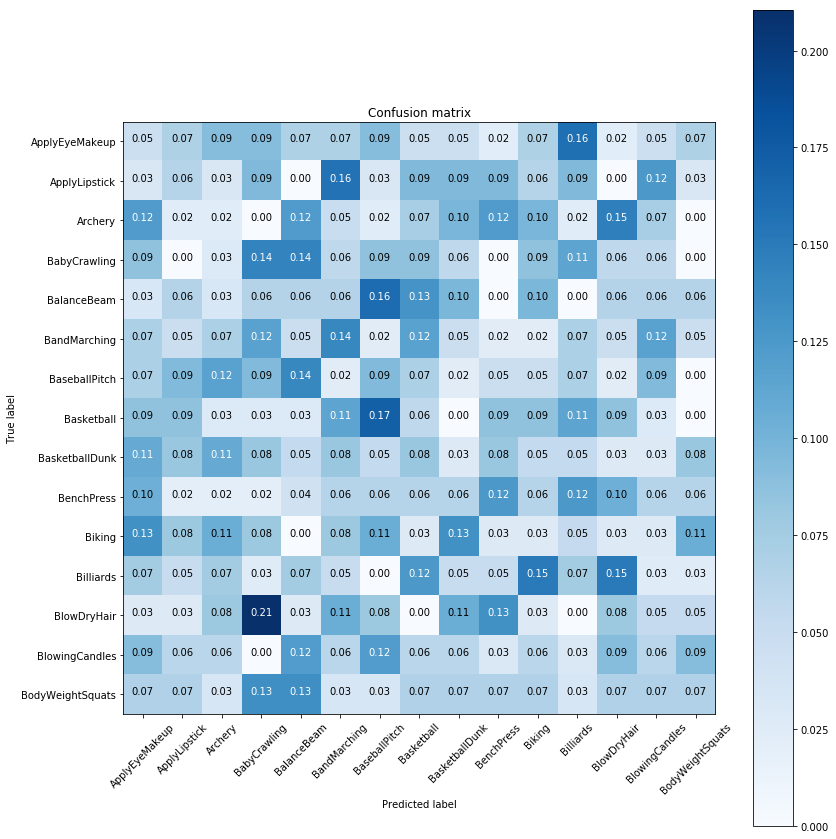

Confusion matrix for SVM
Normalized confusion matrix


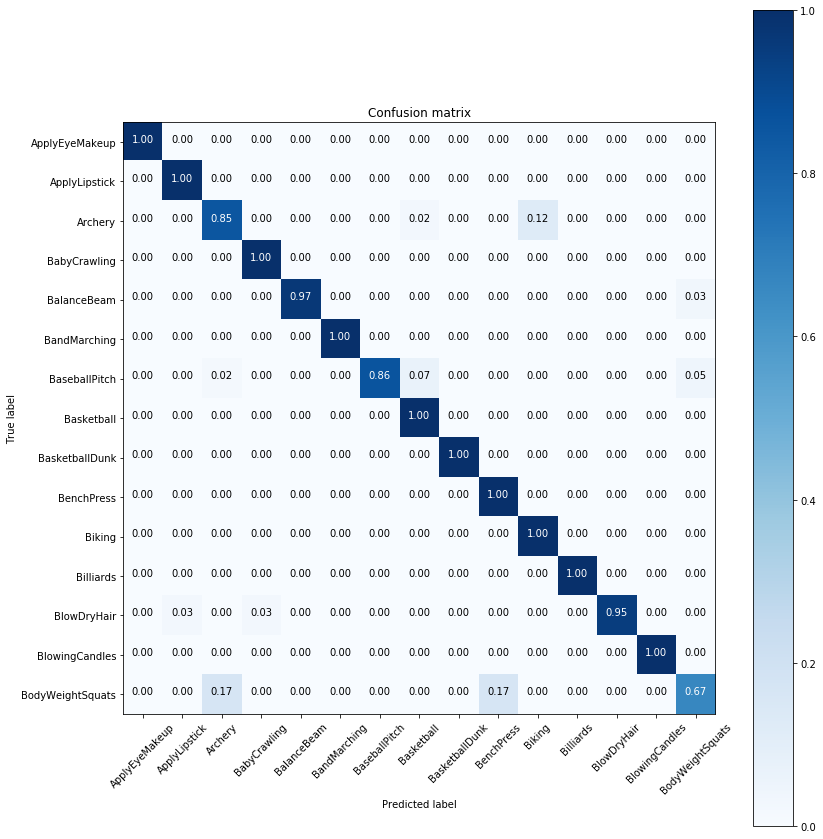

In [45]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

    
classes = []
for f in open('annos/actions.txt','r'):
    classes.append(f.split()[1])
# print(classes[:15])
classes = classes[:15]

# Confusion matrix
print("Confusion matrix for LSTM")
cm1 = confusion_matrix(pred1, label1)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm1, classes, normalize=True)

plt.savefig('confusion_matrx_lstm.png',dpi=300,bbox_inches='tight')
plt.show()


# Confusion matrix
print("Confusion matrix for SVM")
cm2 = confusion_matrix(pred2, label2)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cm2, classes, normalize=True)
plt.savefig('confusion_matrx_svm.png',dpi=300,bbox_inches='tight')
plt.show()
